# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/home/ec2-user/data/toxiccomments_train.csv', my_random_seed=74)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 6380, 'TN': 59464, 'FP': 55185, 'FN': 6627, 'Accuracy': 0.5157924421883813, 'Precision': 0.10363030942905872, 'Recall': 0.49050511263165986, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12885, 'TN': 114505, 'FP': 144, 'FN': 122, 'Accuracy': 0.997916274989033, 'Precision': 0.9889477319825005, 'Recall': 0.9906204351503037, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12951, 'TN': 114598, 'FP': 51, 'FN': 56, 'Accuracy': 0.9991618098640095, 'Precision': 0.9960775265343793, 'Recall': 0.9956946259706312, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12749, 'TN': 103299, 'FP': 11350, 'FN': 258, 'Accuracy': 0.9090681205740427, 'Precision': 0.5290261006680775, 'Recall': 0.9801645267932652, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12877, 'TN': 114506, 'FP': 143, 'FN': 130, 'Accuracy': 0.9978614401203234, 'Precision': 0.9890168970814132, 'Recall': 0.9900053817175367, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 10947, 'TN': 114470, 'FP': 179, 'FN': 2060, 'Accuracy': 0.9824606755655825, 'Precision': 0.9839115585115945, 'Recall': 0.8416237410625048, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 13007, 'Neg': 114649, 'TP': 0, 'TN': 114649, 'FP': 0, 'FN': 13007, 'Accuracy': 0.8981089803847842, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/home/ec2-user/ml/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

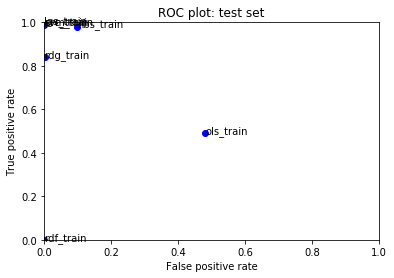

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
20
":::::You can't just make up your own rules.  You have to abide by Wikipedia's policies like everybody else.  If Wikipedia does indeed have a policy that says ""when a clerk posts 'The user is not prevented' it really means that the user is prevented"" then post a link to that policy.  If Wikipedia has no such policy you can't just pretend there is one.   

"
* * * * * * * * * 
71
Oh my god, he pulled the Lorenzo von Matterhorn. Genius.
* * * * * * * * * 
127
hey there i went through the article and tried to fill in the reds by writing articles for the red links, i also got rid of a lot of sub-headers etc. i will try to write articles for the remaining afflictions/syndromes and bios for lesch and nyhan as well. what do think now?  22:58, 9 Nov 2004 (UTC)
* * * * * * * * * 
139
Yes, I saw Timeline of Anti-Semitism.  It isn't fixable, but getting it deleted would be hard.  Sometimes the Wikipedia workflow model just doesn't work. Meanwhile, here's somethin

2686
And the fact that MacEoin and Warburg would refer to it is proof enough of what intellectually bankrupt hacks they truly are, and how valueless anything they have to write truly is.
* * * * * * * * * 
2782
Why do people make weird exception for the title Rabbi? Don't give a person a title that needs a degree that they don't have.
* * * * * * * * * 
2791
I need help with referencing my articles for this person.  it doesn't work

could you help me please so I can no how to reference the article typing thanks.  It is retarded. sorry but it is ..and annoying.  how do I do that
* * * * * * * * * 
2798
Dennis Brown ==

I am User:King Genovese, I have Understood Wikipedia and I am following all rules, I have referenced very well. When I first joined Wikipedia, I had King Genovese and I didn't understand how to Reference, I'm saying sorry and I hope we can leave the past and look onto the future. If you will allow me to creating Mob Related Articles, I'll be out of your hair. Let's be pos

5948
BigK HeX, please keep your petty taunts out of my User talk page. The are beneath me, even as they are clearly not beneath you. (Why on Earth do you feel to compelled to come into my talkpage at all?)
* * * * * * * * * 
5979
You wanna reference? 

Don't delete factual information. Dane dies at the end of SR2, here's your proof 60.242.127.62
* * * * * * * * * 
6000
This is an issue of knowledge. I say that because apostolic session does not mean the same thing between communities. Anyone that knows the history of Ephesus or about the history of the Island of Patmos knows that the other communities mentioned don't have the archaeology to back up there statement let alone the history. There is nothing the RC have that encapsulates the history St Catherines and  the bible. There is no Protestant church nor the Church of England that can say they can show like St Catherine's that their community generated the bible. There is more to this claim than just making it. LoveMonkey
* * * * * 

7318
Spam
Regarding several edits you made, like this one:

Please do not add inappropriate external links to Wikipedia. Wikipedia is not a mere directory of links nor should it be used for advertising or promotion.  Inappropriate links include (but are not limited to) links to personal web sites, links to web sites with which you are affiliated, and links that exist to attract visitors to a web site or promote a product.  See the external links guideline and spam policies for further explanations of links that are considered appropriate.  If you feel the link should be added to the article, then please discuss it on the article's talk page rather than re-adding it. See the welcome page to learn more about Wikipedia. Thank you.
* * * * * * * * * 
7329
I am not evading, Musarabbyahamd is not my ID. Strange!
* * * * * * * * * 
7454
Completely agree. Vandalism is a SERIOUS offence and if repeated you will get a ban. Stop it.
* * * * * * * * * 
7466
Plant italics
Polbot isn't italicizing t

9896
This fact can also be easily VERIFIED.
* * * * * * * * * 
9910
" November 2010 (UTC)

CS, if you give me (or one of my Talk Page Stalkers) permission, we can just copy some of the basic parts to your Archive subpage and your talk page, to get you going. Then you will just need to change the image. I have the search tool on my userpage because I don't know how to add it elsewhere I'm not that good at this stuff, set mine up by copying other people.  (Talk) 13:07, 14"
* * * * * * * * * 
10212
Oppose The title is clumsy and needs changing, and the article needs a lot more content (like most family pages), but a huge family like the Psittacidae needs its own page.   talk
* * * * * * * * * 
10317
Agreed to my redlinking.
* * * * * * * * * 
10367
"

 The Wikipedia Signpost: 28 September 2009 

 Opinion essay: White Barbarian
 Localisation improvements: LocalisationUpdate has gone live
 Office hours: Sue Gardner answers questions from community
 News and notes: Vibber resigns, Staff offi

13498
"

Just one point I'd like to make. Your third-listed  cannot be a requirement, because the article makes no such claim or even inuendo. It only states the facts. (HAL's technically incorrect use of descriptive notation, and HAL's omission of mentioning that White can play a few moves longer before mate.) (The article used to contain those claims or inuendo's, but recently ago I removed them. They were clear WP:OR, and for me, didn't even make sense.) p.s. What part of the game analysis do you specifically want to see referenced? (Please be specific, thanks.)   "
* * * * * * * * * 
13546
Syed Ahmed Khan 

Hi - Yes actually I've still got a lot of info to add to the article. Your comment is right - I was writing in context of the partition of India, which happened 50 years after Khan's death and thus is not properly explained or directly relevant to this article. Thanks for your comments, but do check back in the coming weekend. Rama's arrow
* * * * * * * * * 
13623
"

 Film-book 

15255
Hello Ben, 

If you are going to insert a NPOV header on the page, you are supposed to justify all and every point you have in mind, not completely smash up a page, and then rewrite it with no discussion or debate as a Watchtower PR exercise. Many others here have covered these issues over and over and the page has been approved by two administrators in regard to the eschatology section. My edits were reverting, not altering the main text sections. I only edited the last 1995 bit, and you've said nothing about that, except made unfounded claims. All major changes are supposed to be discussed first, and you have not done that, you have just ripped out the factual material and done a whitewash edit in apologist speak to look like it was all a minor dream or something.

A couple of points I will pick up on were where you claimed in regard to 1799, 1914, 1920, and 1925 etc., that they were “suggestive and purely speculative”, but Ben, not one of those dates falls into your apologist 

17395
Please stop adding inappropriate external links to Wikipedia. It is considered spamming and Wikipedia is not a vehicle for advertising or promotion. Since Wikipedia uses nofollow tags, additions of links to Wikipedia will not alter search engine rankings. If you continue spamming, you will be blocked from editing Wikipedia.
* * * * * * * * * 
17475
Map Request
This article would be better with a map of the Angevin Empire.  I am new to wikipedia.  Does anyone know how to make this request?
* * * * * * * * * 
17483
I stand corrected.  I had to watch the movie once again.  Thats what I get for asking the other four people in the office with me -)   20 March 2006
* * * * * * * * * 
17510
"""Start Me Up"" 
""Rough Justice""
""Satisfaction""

2007- Prince (XLI)
Prince performed a twelve-minute medley of songs that were intersperced with stunning guitar solos in the style of Jimi Hendrix and Eddie Van Halen. The show was performed in heavy rain that drenched the stage, shaped in the art

Hmmm... well I expected that it would probably be more complicated than I first thought, so I guess some thought needs to go into individual cases. Do you have information about the 2nd Baronet Grosvenor (or however he should be correctly titled) I haven't been able to track him down to plug him into the Duke of Westminster page.
* * * * * * * * * 
19035
Thanks, I did indeed.Larf
* * * * * * * * * 
19101
I didn't do anything to the Air Force Blues webpage imbosile!
* * * * * * * * * 
19148
"

 What is Pakistan then? 

This article once again made me think about Pakistan and Bangladesh {former East Pakistan}.Muhammad Ali Jinnah claimed that Muslims of the subcontinent needed to have their own nation since they could expect no justice ""at the hands"" of India's Hindus.But if the population of Muslims in present day India is more than the population of the Islami-Jamhuriya-e-Pakistan than what exactly is Pakistan?If Pakistan was created solely for the purpose of being a homeland for Musl

21604
"

Blake 
Hey . I'm trying my best to return to the English Wikipedia. I'd never expect that Mr. Tako would understand what transpired, don't even know why he's answering your question. If you read the recent stuff that showed up on my talk page, you'll see that this isn't a simple case of sock harassment... I got screwed, plain and simple. If you ever need anything, you can contact me on my Simple English Wikipedia talk page. There, I'm currently working on a Batman: Arkham Origins page. I'm trying my best to use all of Doc Tree's advice. I was very glad that he actually wanted to understand my situation. ""Internet drama"".......WTF? 

I also have a favor to ask of you. Would you mind adding this source that confirms Kimberly Brooks as Barbara Gordon to the article. - Thanks Blake. -   
Here is the source:
 http://www.pcmag.com/article2/0,2817,2426342,00.asp"
* * * * * * * * * 
21605
Deletion threats; not ban==

Sorry, you're right. I misremembered the exact nature of your unsa

24112
"

 Edit request from LikeLakers2, 1 October 2011 

Please remove {{pp-semi-blp|small=yes}} from the page.

Note to admins: As an alternative, you can remplace {{pp-dispute|expiry=October 4, 2011}} and {{pp-semi-blp|small=yes}}, and replace it with this: 
{{subst:User:LikeLakers2/spp|expiry=October 4, 2011|reason=dispute}}
This should automatically detect protection settings and add protection templates as needed. (If you use my template, please subst it. Make sure to click ""Show Changes"" to make sure it adds the right templates, though)

 (talk | )  "
* * * * * * * * * 
24137
"

 Informal mediation at Nazism 

Hi TFD, this is Mr. Stradivarius from the dispute resolution noticeboard. If it's not too much trouble, would you be willing to comment in the informal mediation thread that I started at Talk:Nazism#Informal mediation? As one of the main contributors to the article, we really need your input to have a good chance of resolving the issues there. All the best. —  ♫ "
* * * 

26900
Expect us Soon
Realy, why can not we discus over and with time build more realistic view.
* * * * * * * * * 
26975
"

 one more goodbye 

sorry to see you go man, your work was superb and you will be greatly missed.  ™ "
* * * * * * * * * 
26982
I am requesting a GF unblock
* * * * * * * * * 
26984
Scratch that.  Didn't realize you were so new here.  I'll take care of reverting your erroneous edits.
* * * * * * * * * 
27096
"

D dogging

A Proposed Deletion template has been added to the article D dogging, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but this article may not satisfy Wikipedia's criteria for inclusion, and the deletion notice explains why (see also ""What Wikipedia is not"" and Wikipedia's deletion policy).  You may contest the proposed deletion by removing the {{dated prod}} notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please c

28851
"

What's wrong with the Punjabis? Creating division among Pakistanis and then pretending to be ""musleheen"" (peace makers)?

Al-Quran 2:11 When it is said to them: ""Make not mischief on the earth,"" they say: ""Why, we only Want to make peace!"""
* * * * * * * * * 
28855
"

You should know my gender, if you do not it means that you have blocked me without even understanding the reason for Lbs existence - which was clearly stated repeatedly on the TM talk page and all editors were aware of it. ) And my religious views are on my profile page - clearly. They are there, because I have been spending to much time on the TM page, but I  do want people to whaatever my - and we all have them - POV is so that any edits or contributions i make should be seen in that light. 

No where above have I made a ""personal"" attack on you, I asked a question and it was a genuine one. Perhaps you are being slightly over sensitive. But then we all do have our moments - I know I do ).

On LBs block 

31064
In English, we do traditionally say the Ukraine, the Crimea, the Peloponnesus, the Sudan, the Lebanon, the Barbados, the Wash, the Skagerrak, the Kattegat.
Just off the top of my head,
* * * * * * * * * 
31118
"... And what the HELL does ""attack against the gender"" mean?!?!!? ... Oh, wait. You're one of those that actually buys into the whole ""conspiracy of misogyny"" thing. Ugh. You know, I have my criticisms of Gail Simone's writing, but I usually enjoy it. I just wish she weren't dedicated to being such a hypocrite, liar, and misogynist, and that some of her fans didn't join her in it. Whatever, I should have learned looong ago that actual facts and Wikipedia have a restraining order. "
* * * * * * * * * 
31126
The split has been made, although the The Ladykillers (2004 film) page may need editting and reformatting.
* * * * * * * * * 
31238
Blanking of Yes we can 

The only reason why I thought of that is because I couldn't help myself. Next time, I will use the sandbox.
* 

33145
Factual correction to
* * * * * * * * * 
33271
"

 Gaza Reading List 

 Christopher Hitchens, 'Bad Timing', Slate, 05/01/2009
 Akiva Eldar, ‘Is an Israeli Jewish sense of victimization perpetuating the conflict with Palestinians?,’ Haaretz, 30/01/2009  
 Benny Morris, ‘Why Israel Feels Threatened,’ New York Times 29/12/2008 
 David Rose,'The Gaza Bombshell,' Vanity Fair, April 2008 
 Charles Glass,'The Ordeals of Gaza,' SOAS Lecture 22 Jan, 2009
 Robert Fisk, 'Leaders lie, civilians die, and lessons of history are ignored,' The Independent 29 December 2008
 Anthony H.Cordesman, ‘The War in Gaza: Tactical Gains or Strategic Defeat,’ Center for Strategic & International Studies,  January 9,2009
 Norman Finkelstein, ‘The Cleanser: Lobbyists Whistle Up Cordesman to ""Prove"" Israel Waged a Clean War in Gaza,’ Counterpunch, February 19, 2009 
 Henry Siegman, 'Israel’s Lies,' London Review of Books, 29 January 2009  
 John J. Mearsheimer 'Another War, Another Defeat,'  The American Con

35710
(Yes, Mrschimpf, I saw your user contributions list)
* * * * * * * * * 
35746
malware adequately includes viruses with no particular adverse effect - they were not asked for.

Virii is a bad word for several reasons.
* * * * * * * * * 
35775
Contested deletion 

This page is not unambiguously promotional, because... (your reason here)   

I don't believe it is promotional or ambiguous, because it brings the data sent forth by the most authoritative Italian sources: radios and televisions of state (RAI, MEDIASET, Radio Italia, MTV Italia), national newspapers (Il Gornale, Il Corriere della Sera, Il Messaggero, La Repubblica, La Stampa) and more important italian music magazines (Musica e Dischi, Ciao 2001, TV Sorrisi e Canzoni) that takes back their sales'ses esteemed of records from statistic institutes as DOXA, RAI ISTITUTE or other specialistic surveys. The data and the certifications of the Anglo-American model, in Italy they have departed only since 1995 with the creation of 

Inka hieroglyphics? 

Umm, wasn't it that the Inkas had no forms of writing (apart from the k'ipu)
* * * * * * * * * 
37387
"

Please do not add commentary and your personal analysis of an article into Wikipedia articles. Doing so violates Wikipedia's NPOV rules and breaches the formal tone expected in an encyclopedia. If you would like to experiment, use the sandbox. Thank you.  (TalkˑContribs) "
* * * * * * * * * 
37404
awww 

your not simple dont be hard on your self
* * * * * * * * * 
37423
The context here, is that the authorities cited are themselves guilty of dumbing down the material to a lumin oozing math-blob. There will be many others who have swallowed this sparkling jewel of the murky depths hook line & sinker. Dismissing the problem out of hand is no less problematic. It is worth talking about.
* * * * * * * * * 
37491
Hi. Not at hand, unfortunately. I am in agreement with the basic idea of calling the priestess Pythia and the article accordingly. I was just trying to poi

40337
"

I understand now what you did.  For example, in this edit, you changed it so ""Hilbert's sixteenth"" appeared after ""Hilbert's twelfth"" in the ""Unsolved problems in mathematics"" category.  Nothing wrong with that!  (I was just having a mental block understanding the effect of this edit until now.)  Thanks for the references.—talk "
* * * * * * * * * 
40351
Request box
Sir do not remove it
* * * * * * * * * 
40388
"

 GAN of Frill-necked Lizard 

Hi, I have given my initial comments on the article on the talk page. It is on hold awaiting improvements. If you need any help feel free to ask. [[User talk:Triplestop|'''Triplestop''']] x3 "
* * * * * * * * * 
40420
Have you ever heard of Monaco? Liechtenstein? Luxembourg? Malta? The idea that areas of a few hundred thousand people are too small to be independent is ridiculous. You mention loyalty, why should I feel loyalty to the British state? I did not choose to live here.
Cornwall is a recognised political entity within the U

43307
Oh, it's moved to grand farce. They're running all over the place, trying to ruin my reputation. It's pathetic and they're free to make fools of themselves for all I care, just so long as they stay the hell away from my user page, because it's mine.  Do me a favor; take a look at Ayn Rand and decide for yourself if it needs further changes.
* * * * * * * * * 
43338
Interesting. I had no idea that worked, and no, I don't know of another way to do it.  And, I was just pulling your leg. You have certainly been diligent and industrious here. Congratulations and well done.
* * * * * * * * * 
43383
"

 New Famous Committee 
I entered a new famous Committee, it has been formed in Melton Australia, It is farly well known in the Melbourne/Melton area. If you find it useless pls tell me before editing, at least give me a chance to explsin properly, as im not going to now because its a long story. "
* * * * * * * * * 
43412
May I ask why the 'Popular Culture' section has been removed?
* * *

45516
"
{| width=""100%"" style=""background:transparent""
{| width=""100%"" style=""background-color:#""
|style=""width: 50%; border:1px solid #; background-color:#; vertical-align:top""|
 Hello 12chaser34, and Welcome to Wikipedia!
Please remember to sign your name on talk pages by clicking  or using four tildes (~~~~); this will automatically produce your username and the date. Also, please do your best to always fill in the edit summary field. Below are some useful links to facilitate your involvement.
Happy editing!  /Talk 
{| width=""100%"" style=""background-color:#""
|style=""width: 50%; border:0; background-color:#; vertical-align:top""|
 Getting started Introduction
 The five pillars of Wikipedia
 How to edit a page Finding your way around Table of contents
 Department directory Editing articles How to develop an article
 Manual of Style
|style=""width: 50%; border:0; background-color:#; vertical-align:top""|
{| width=""100%"" cellpadding=""2"" style=""vertical-align:top; bac

47339
I hope you aren't suggesting that as your source of credibility for this edit?
* * * * * * * * * 
47399
|decline=No doubt. Legal threats are not tolerated on Wikipedia. :==( o )
* * * * * * * * * 
47407
"

 Experimental evidence - reference would be good 

Perhaps a reference should be added to the value of 10 years. The paper given (K. Hagiwara et al., ""Particle Data Group current best estimates of proton lifetime"", Phys. Rev. D 66, 010001 (2002) ISBN 978-06848657680) dates from 2002 and is presumably from the 2001 Super-Kamiokande results. 

You will be aware that the average non-specialist reader will have seen 10 years, or just 10^33 years, and this is the value that other google sources bring up - from the same Super-Kamiokande experiment. e.g. the hyperphysics.phy-astr.gsu.edu site 

""As of [2001], it seems that the proton lifetime has been pushed out to [at least] 10^33 years."" (which point?)

Isn't 10^33 strictly equal to 10?   "
* * * * * * * * * 
47424
Mahan 

I’ve 

49277
Well I think its cool but anyways I couldnt see any other picture worth fitting but if u have a suitable image in mind please be my guest.
* * * * * * * * * 
49288
They say it's from the Atlanta Journal-Constitution. Not sure if you'll be able to find anything explicitly saying they're (the Colliers) related, but they probably are. –
* * * * * * * * * 
49354
, 23 February 2007 (UTC)

If you can find a single source that will say Canada (New France) considered New York State part of their own territory then you may post your link. The burden of proof is on you!!  Until you can find that proof, you may not post fictious (or shall I say, your personal opinion based on 'an argument can be made') content and links.
 22:45
* * * * * * * * * 
49396
Proposed deletion of George Herbert Scott 

How exactly does WP:BLP apply to George Herbert Scott, given that the article's subject died in 1930?
* * * * * * * * * 
49451
Thanks so much for removing. While I don't have 500 edits I have been a

51458
The reason was an attempt to reach a consensus instead of revert war, IMHO. talk
* * * * * * * * * 
51493
Someone keeps changing 

http://en.wikipedia.org/wiki/Tier_1_capital

To the wrong definition. 

Tier 1 Ratio is Tier 1 Capital / Risk Adjusted Assets (RWA). If someone deposits $10 and the bank lends out all $10 assuming a RWA of 90% then the bank would now have risk adjusted assets of $9 ($10*0.9) and it would have equity of $2 implying a ratio of $2/$9 or 22%.

This is what I have written which I know is right.

Someone keeps changing it to something else.
* * * * * * * * * 
51500
And how about you mind your own business.
* * * * * * * * * 
51538
Time Magazine 

This song got onto the TIME . Not sure if you can meld this ref into somewhere.
* * * * * * * * * 
51541
"

 Only Coanda-1910 ""unsuccessful"" in the entire Timeline of aircraft engine development. Quite strange! 

I have noticed that the entire timeline of aircraft development, ranging from 1848 to 2004, has a sin

53810
, 5 February 2006 (UTC)

The spoken word version is nowhere close to the current content of the article.  It was a good enough reading (ignoring the slight speech impediment, anyway) but it might as well have been randomly linked to some other article's reading, given the wholesale changes to this article since the recording was made.  IMHO, of course.  -) ⇒  T/C 23:31
* * * * * * * * * 
53871
"

I've tried to explain to you problems with statements like ""all mainstream jewish groups oppose jews for jesus"".   If you can't understand this I'm not sure where else this can go.   Perhaps you might benefit from visiting the talk page off WP:NPOV and some other editor can explain why this is not permissibile at wiki.   Their are indeed many pov-pushing elements to this page.   Things like the gigantic ""Christianity"" template used to ""warn"" people abot this group.
As far as the blockquote, the combination of footnotes  and poor writing seemed to indicate it wasn't a quote.  It isn

56835
" * 21:50, 2005 Jan 24 (UTC)"
* * * * * * * * * 
56836
"

 ""Russian scare"" in Pacific if late 1800s 

Hi there, you might be interested in creating this article. In the 1880s & 1890s Australian colonies & New Zealand armed themselves against what what later called the ""Russian scares""  fears of Russia controlling their sealanes and even invading. My personal theory is that this fear was built up by British arms suppliers rather than any political facts, but you seem in a position to write a balanced article if you're interested - we don't hear much from the Russian point of view on this. regards. Rod   "
* * * * * * * * * 
56888
"
 I have actually replaced the contents with the above sockpuppetcheckuser notice, as I think this is more appropriate than just deleting it.  ''''''''''/talk|contribs\ "
* * * * * * * * * 
56905
"

 Complex issue 

 This is quite a complex issue. There have been a few cases around the world where individual officials have solemnised marriages (e.g. 

59909
"
Right, I requested, and succeeded in getting, page protection for two weeks until we can fix this mess. (Talk) "
* * * * * * * * * 
59962
and www.cornsilks.com sockpuppets
* * * * * * * * * 
59984
I propose that the article could be updated each day should any editor be so inclined and as long as the information is verifiable.  That's what Wikipedia is: a source of information that -upon occasion- acts as an almanac.  But I'm not going to do it...I'm not that invested.  But if somebody else is, God bless their efforts.207.237.230.18
* * * * * * * * * 
60050
"

My two cents

First of all, let me just say that I'm very happy Xandar is no longer blocked and I look forward to working together on improving the article in the next few days. This place just isn't the same without Xandar. 
On the substance of the criticism, I agree on some points, but disagree on the fundamentals. In particular, I'm rather shocked that Xandar suggests we should remove History, which is the most importa

There's a photograph of him thus attired in The Northern Magus by Peter C. Newman, although admittedly it was taken just outside the chamber.
* * * * * * * * * 
61671
Unsourced images
You still need to give the original URL, although however that should be ammended since we can scan in the images... now that is a point to ponder.
* * * * * * * * * 
61729
I just mentioned the social conflict, because the contemporary crisis of Judaism was less a conflict between Orthodox and Reform movement, but a social gap between a ruling minority, consisting of families which had bound together religious authorities, academics and wealthy merchants through marriages, and a ruled majority in the Jewish communities and town ghettos whose poverty had dramatically increased. This is not only the social context of the conflicts between Maskilim and Orthodox Rabbis or Maskilim and Reform Rabbis, but also between Orthodox authorities and mystic movements like Hasidism. Hasidim in Galicia and Bukovina usual

64701
Re: Rollback 

Thanks for your help and support.  I do know better now, although I can't say it was a pleasant learning experience finding out that my greatest enemy was myself. -)
* * * * * * * * * 
64802
I've done a few more:
Wikipedia:Featured picture candidates/Port Vell, Barcelona
Wikipedia:Featured picture candidates/File:Danaid Eggfly Hypolimnas misippus.jpg
Wikipedia:Featured picture candidates/File:Austrolestes annulosus.jpg
Wikipedia:Featured picture candidates/CalnePigs
Wikipedia:Featured picture candidates/Lewis Hine photography

Have I gotten them more-or-less alright this time?
* * * * * * * * * 
64862
Hey, how are you? 

I remember back when you were just a Bavarian creampuff, long before you became a mass of twitchy muscle!  69.158.141.216
* * * * * * * * * 
64870
Cyberbot I not clerking WP:RFPP 

Hasn't been around to clerk for slightly over 12 hours, not really sure why but giving you the heads up on that.
* * * * * * * * * 
64986
"

 subpages 

Please delete al

68367
I'll try to find some scholarly sources for the article, when I have some more time. Let's wait, I think.  (t)
* * * * * * * * * 
68378
Does anyone think that reason that UK was joint bottom on points was due to the ethnicity of the singer and the prejudiced views in pre-dominantly Eastern European countries?  UK were not thee best but certainly better than most.  (Just a thought)
* * * * * * * * * 
68433
"

 WP:FEFS 

I would put this on the article in question's talkpage with an editprotected but the talk page is semiprotected.
WP:FEFS still says ""You can find the talk page for any article by clicking the ""discussion"" tab above the article title."" I believe this has since been relabelled and thus requires editing. 128.232.241.211  "
* * * * * * * * * 
68437
-Russell29 2 April 2007, 16:26 (UTC)
* * * * * * * * * 
68471
Yes I know. I did get your first warning and all I've done since is discuss on the talk page. What are your thoughts on the notability of the section as per m

69606
Hello, friend! How is the comedy routine going on the arbcom Q&A;?  Still chasing away your potential supporters by attacking them?  How is that working out for you?  You realize that is comedy gold, right?  Who said Germans didn't have a sense of humor?
* * * * * * * * * 
69634
I replied to this earlier but someone deleted it along with your second warning for the same thing (after which a block came). Here it is again: How many times do you think you can warn me for the same thing?
* * * * * * * * * 
69688
Whether or not you choose to call your organization a political party, it still didn't achieve anything of note (such as running a candidate in elections). As I said, Wikipedia is not a place for political propagation; your organization may not be propagation, but your article is. -
* * * * * * * * * 
69689
"
I'm referring to the ""Killing Patton"" page, not the Bill O'Reilly page.  Thanks.  Jimintheatl"
* * * * * * * * * 
69704
"
Thanks,  I share your concerns about discoura

72331
On a side note this again is yet another antique quinolone (noroxin aka norfloxacin) first approved by the FDA in 1986, and like ciprofloxacin there is no data on the FDA site for this drug between 1986 and 1994.  And the NDA is not available.  So there is going to be very little to work with when it comes to updating the article.  I would be shocked if this was still in use, let alone considered to be a commonly prescribed quinolone, here in the States.
* * * * * * * * * 
72418
please go to link to support page for deletion 

http://en.wikipedia.org/wiki/Wikipedia:Articles_for_deletion/Pit_Bull
* * * * * * * * * 
72454
"

If the ""major algorithm"" you are referring to is the CSSR algorithm then an article ought to be started on it.  Otherwise, I concur with another contributor to this page that
the entry on this person be deleted.   "
* * * * * * * * * 
72517
"

 Re: Your ""minor"" edits on 29 April 
 The subgrouping of Japan is discussed at Talk:List of regions of Japan. You c

73905
No evidence that Ernst's research is bias has been presented. If an editor thinks Ernst is bias that is there personal opinion but on Wikipedia we edit according to policy. Please ses WP:RS. Ernst passes the RS test with flying colors.
* * * * * * * * * 
73990
Article needs updating.... 

Woolf is not on the ABC any more - he's running for the Senate.
* * * * * * * * * 
74035
The number of univ studs
It increased from 110 to 114. Without any reference to further increase, the 114 must be kept.
* * * * * * * * * 
74100
If you want to post rubbish about Meyer Moran here, you will have to prove first that the test includes a test of ultrasonics. David Moran himself notes that his test is NOT a test of ultrasonics, and his test discs don't contain ultrasonics. (  )
* * * * * * * * * 
74115
Bull Dog is NOT an exception 

His name refers to his ability to grow horns. The fact that he is a bulldog makes it a pn, but not an exception.
* * * * * * * * * 
74122
My understanding is that I c

77215
Contradictory numbers in Energy Content table 

This isn't my field of expertise, but I noticed what seem to be some contradictory numbers or bad conversions in the Energy Content table. For example, Aviation Gasoline is shown as having a lower number of MJ/liter and BTU/gallon than Regular Gasoline, which doesn't sound right. But when converted to MJ/kg, the number is higher than gasoline.

I have another remark regarding the Energy content section. Is the displayed energy content the true energy content or the energy content when used in a conventional internal combustion engine (this would change the figurs greatly as eg gasoline is burnt here with 20% efficiency; while hydrogen is burnt with 40-60% efficiency)
* * * * * * * * * 
77407
Is there a way i can like make anote or something tellinf people he has the albums and stuff but not put it on there like i was doing.
* * * * * * * * * 
77420
"
And you really need to familiarize yourself with Randy because what I said after al

"

 A barnstar for you! 

  The Original Barnstar Thank you for your contribution. It good to know someone is sufficiently interested to find this piece of research.  Kevin Bree "
* * * * * * * * * 
79250
"

 Please do not vandalize pages, as you did with this edit to Archbishop Ryan High School. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
79374
"

More ships than noted?
About halfway through the page, in the ""Capsizing of the Rose Pink section, the text reads [edited]

""and his fleet of two ships (the Rose Pink and the Fancy,...... and Low—now captaining the schooner Squirrel""

Fine, he had two vessels, neither had that final name, so where did the Squirrel come from?   
I've expanded the sentence to clarify this.  龱 "
* * * * * * * * * 
79470
what did you mean busier?
* * * * * * * * * 
79493
There are several definitions of Kinneret - which one?
* * * * * * * * * 
79535
"
 Looking at Category:WikiProject Washington Metro articles, there app

80851
"

 That reminds me of a line in the movie ""Full Metal Jacket"".  Something to the tune of, ""I want to be the first kid on my block with a confirmed kill.""   "
* * * * * * * * * 
80873
"

As the wiggles would say, ""Bew-dy mate!""  (talk · contribs) "
* * * * * * * * * 
80904
It has been vandished. I had a picture section and it was removed CF Captain
* * * * * * * * * 
80910
LSAG Report Published 

Hello. I was just reading through Digg science and found this bit of rather sad and un-nerving news piece: http://www.telegraph.co.uk/earth/main.jhtml?xml=/earth/2008/09/05/scilhc105.xml

It's shocking to think that people would do that. In any event, I'm actually posting the article to draw attention to the fact that the LSAG report has now been published in the Journal of Physics G: Nuclear and Particle Physics. Should this be added to the article?
* * * * * * * * * 
80913
"give me other ""favours"". Call me again soon... ;)"
* * * * * * * * * 
80983
someone needs to check the so

82764
":Thanks for the opinion.  I agree.  By the way, were there flashing red lights and pop-up banners saying ""nyah-nyah, you can't edit!""?   (talk) 15:00, July 23, 2005 (UTC)

"
* * * * * * * * * 
82864
reverted back to above edit because kbits are in there infancy as a industry standard
* * * * * * * * * 
82879
"
Garden Island, Australia is a redirect to Garden Island because it is itself ambiguous. There are fifteen places in Australia currently named ""Garden Island"": five islands in Queensland, two islands in South Australia (plus Grindal Island was historically known as Garden Island), two islands in Tasmania, an island (which is also gazetted as a suburb) in Western Australia, and four islands and a peninsula in New South Wales. Hesperian "
* * * * * * * * * 
82936
"

Media

Yeah, I'd do something much like the Lethbridge list. Also take a look at List of Greater Sudbury media, particularly the ""Out-of-market radio"" subheading — we could do something similar for the Hot F

84621
"
Hi! Dimitrov has published stories for children. Biographical note in his book ""The name and the mind"" (Skopje 1999) referred to three separate editions with stories for children - ""Shepherd boy"", ""Goodbye childhood"" and ""Where we are  children"". Regards,   "
* * * * * * * * * 
84643
REDIRECT Talk:Jenny Wade (actress)
* * * * * * * * * 
84657
"

Why don't we change the title to ""Franciscan Order"" since that already redirects to ""Franciscan."" That's what the article is about, as far as I can tell, the Franciscan Order - and I would imagine everything that is ""Franciscan"" can be placed under the umbrella of belonging to the Franciscan Order.   "
* * * * * * * * * 
84691
Can we get this page protected
I'm talking about the untitled Batman Begins sequel as this user keeps posting B.S about Michael Keaton, Robin Williams and Mark Hamill being considered for the role of The Joker in the movie. He puts up articles on other sites (which have surprisingly come up today whe

86467
Lincoln Caplan (now working in a non-profit)
* * * * * * * * * 
86549
Moved. By the way every logged in Wikipedia contributor could do that.
* * * * * * * * * 
86684
Wikzilla has a long memory FREEPSBANE YOU TROLL 

You will never edit again. Wikzilla will hound you every time you do so.
* * * * * * * * * 
86714
"

On the subject of the German Uranium, the obituary of Capt. Tibbets in the respected Guardian Newspaper (UK) included the following reference:

""At the end of the month, Little Boy arrived. It symbolised global war. Some of its uranium was from the Congo, confiscated from the Belgians in 1940 by the Germans and snatched from Soviet-occupied Germany in 1945 by an Anglo-American special unit.""

Is there any historical record to back this up?

The full obituary can be found at:

http://www.guardian.co.uk/military/story/0,,2204009,00.html

 "
* * * * * * * * * 
86728
"

 Hey 

I saw what you have done to infoboxes. Great job! I just changed the Big Ten's navbox from this

Thank you very much, but I can make all the same points from the peanut gallery.  There's no need to run for the committee and stress out my haters. That, and I don't have enough time available to do the job properly.   Talk
* * * * * * * * * 
88638
I am from the AACD and posted the information pertaining to the Academy. Is that ok for me to do?

Thanks,
Anna Velten
* * * * * * * * * 
88653
I am not an anti-semite 

Enough said. Stop trying to smear me as one. I request a full apology from your for your blatantly false and hurtful accusation. You may contact me via Special:Emailuser/Blu Aardvark.  | (talk) | (contribs)
* * * * * * * * * 
88697
, 8 June 2009 (UTC)
No need to incorporate it into a single paragraph - the section will do, and that can be fairly extensive.  In flight, so I will look at the rest in due course   18:28
* * * * * * * * * 
88721
Maybe I will in due course, but answer me this: have BigDunc's communications focused on articles, not other editors? He has accused me

90162
I used the expression 'fictionalised account' advisedly, to emphasise the fact that Dahl's story is not, and was not intended to be, a plain, factual account, but rather, a good story.  Based as it was on his interview with Butcher, is clearly broadly factually accurate, but the author was a journalist and novelist, not an historian, and the presentation of the story is coloured by artistic licence, with very boldly characterised individuals.  All these issues are discussed in some detail in the two papers by Hobbs which are cited.  In spite of Dahl's early publication of the story, there is still much that is, and will remain, unknown about the details of the discovery — which is the usual state of affairs with treasure finds.
* * * * * * * * * 
90173
After all, http://www.ado-world.org/ consists of West Syriacs.
* * * * * * * * * 
90227
Disneyland past attractions
Saw that you had touched the disneyland article (xlate to It! wow): I started working on List of past Disneyland at

92862
You can find people with better grammar on Friends Reunite, but that probably doesn't apply to you as appear to be someone that doesn't have any social skills
* * * * * * * * * 
92910
Cause you dared question the legitimacy of Orgone.
* * * * * * * * * 
92954
Interesting, I've had a bit of a look at it, and I'll probably give it a go at some point.  00:28, 9 Dec 2004 (UTC)
* * * * * * * * * 
92994
I missed that piece - I was reading p.35.  Sorry.  I'll put it right by the end of the day, as well as Oak and Lurcher.  Thanks for your patience.
* * * * * * * * * 
93022
The biased Greeks constantly writers of this Article.
* * * * * * * * * 
93032
Any contribution made with this user identification was made by me when, unintentionally, not logged in.
* * * * * * * * * 
93036
This is already in the article. - Ghost
* * * * * * * * * 
93052
I'd like to add that the content dispute is with the article itself. The dispute in the talk page is whether the discussion belongs in the talk pag

94851
"

 Ed, we all have our biases, you and me both.  My concern about the article is that it needs to cover a lot of bases.  Broadly speaking, to be fair to all parties concerned, let's acknowledge that a) damaging quotations are a part and parcel of partisan politics, b) there is debate about whether and when such quotations are legitimate, because c) some can be taken out of context, while d) different politicians exhibit different speaking styles and such styles can be the source of parody and such parodies are often based on at least some degree of truth, and e) sometimes politicians really are dumbasses.  Taken in a broader context, that is how artististic political characaturists and comic impressionists make their living.  Did Carter really smile broadly and instantly?  Did Ronald Reagan really say ""Well"" at the beginning of sentences?  Where would we be without Dana Carvey and Rich Little?  Obviously, this is an issue that both you and I feel strongly about.  Perhaps our b

97347
"

 Cited in June 2006 Scientific American 

Scientific American ran an article on Sudoku in their latest release (which had a lot of the same info you can find here in it...) and put this page under the ""More to Explore"" section at the end of the article.  Just a heads up  "
* * * * * * * * * 
97403
2006 Season 
Will they stay in Toronto or will they move?, and what about added the 2006 Season to the article? anyone help thanks.
* * * * * * * * * 
97422
"Actually Koskie was a Minister under the Conservatives, and then later left for the NDP. The Koskie family have been long-time NDP supporters going back to at least the Allan Blakeney years.  

I think this whole controversy really calls for a page entitled Saskatchewan Legislative Assembly Expense Account Fraud Scandal, where the charges and convictions of each member, and support staff like Scraba can be described in detail.  There is a book entitled ""SaskScandal"" at your local library which might be useful as a starting p

99054
"

 They always will be, a history of conquest and assimilation, hard won independence and also strong opposition from people who want Britain to be Britain (not Welsh, or Scottish etc.).  My grandmother (yes that close) was thrashed for speaking welsh in the playground of her school (an experienced mirrored in First Nation people in your country) and a culture was almost wiped out at the time.  Those things are within living memory so advocates of ""we are all British really"" will get a  strong response.  Same on the Irish pages where memories of cultural assimilation are also strong (and of Cromwell for that matter.  I remember being on civil rights marches in Belfast in the 60s as catholics did not have a vote, something a lot of people forget or don't know (and still have the scars of B-special brutality from that).   I could go on, but its not an academic issue for many editors, it is their lived reality and history.   TALK "
* * * * * * * * * 
99082
, 17 October 2008 (UTC)

101805
The status quo is an argument that needs to stop. Editors have opposed it for some time and it should have been removed months ago. Editors edit warred and eventually we stuck all the names in. I don't see that as status quo or consensus over a long term. And maybe we should get a count of how many editors have edited it in over the last year. I can think of one or two editors alone who probably have huge numbers on this. It seems only fair to get the whole scope. And your count also fails to recognize the number of dirfferent editors that agree with the reasoning to remove.
* * * * * * * * * 
101807
Please discuss on POI and not revert everything 

Please discuss the various open discussions at Talk:Person_of_Interest_(TV_series). I have been trying very patiently to be collaborative, but you don't offer any compromises, instead choosing to revert the various compromises I offer without trying to convince me of the appropriateness of the logic. You have not even tried to explai

102981
"Welcome!

Hello, Mrfock, welcome to Wikipedia! Thank you for registering an account with Wikipedia. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
 The five pillars of Wikipedia
 How to edit a page
 Help pages
 Tutorial
 How to write a great article
 Simplified Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and ask your question there. Again, welcome!   (Talk • Contributions • Log) "
* * * * * * * * * 
103038
"
But Woodrow is not actual christian name but his mothers maiden name. The current president or his father are not filed under ""Walker Bush"".  (talk) "
* * * * * * * * * 
103092
"

 Deleting ""Future World Music"" Article 

Hi,
Sorry to disturb,
It's just I'm not fimiliar wit

105888
Please rewrite the Secret Army episode guides. I do not wish to have my original text featured on Wikipedia. Thank you.
* * * * * * * * * 
106014
Most mountains are part of a mountain chain/range, and while many are tall, their prominence is reduced due to them being part of a, say, ridge. The piece of information concerning prominence and membership in a given chain, if any, is vital. It's not a matter of life and death, but your edit removes that information. Reword, by all means, if you hate the word 'standalone', but include that information. If you don't, I will have to put it back as it was. —
* * * * * * * * * 
106066
"Hi. You should be aware of the following official Wikipedia policies - this is an excerpt from WP:EL:

 Links normally to be avoided 
 
Except for a link to a page that is the subject of the article or an official page of the article subject—and not prohibited by restrictions on linking—one should avoid:
 Any site that does not provide a unique resource bey

107785
The shemash or 'attendant(9 letters) candle' is the 9th candle on the Hanukkiah(9) or Hanukkah(8)/Chanukah(8) menorah(7). Hanukkah(8)/Chanukkah(8) is an eight-day(8) festival(8). - Brad Watson, Miami, FL 64.136.26.22
* * * * * * * * * 
107852
Gloat? Besides the obvious point that my words in no way show any reveling in your present circumstances, I was just recently blocked myself; why, then, would I gloat? To the contrary, I was pointing out, in contrast to your friend Merkinsmum's evaluation, that, in my experience, your approach to editing at Wikipedia has been, to put it lightly, almost consistently troublesome, despite a few glimmers of collegiality here and there. That's all.
* * * * * * * * * 
107969
SA ConCon 
But surely it had something to do with his decision to hold the referrendum. It showed that people wanted a reduction in members terms from 8 to 4. This is the option being given at the ref, along with total abolishion (which won't happen, no way enough people will

109946
October 2014 (UTC)

. Bed now. Details and many refs tomorrow. But look - what a pity we can't all go to that, Dahl and Friedrich both!   19:40, 20
* * * * * * * * * 
109971
Independent is written next to political position, I think it's rather clear what independent is referring to. What I'm saying is what's taught to students in high school. I hope atleast some of you finished high school.
* * * * * * * * * 
110073
Merged and redirected.
* * * * * * * * * 
110176
a f c chickenley said mr ashley hunt the first manager
* * * * * * * * * 
110228
fight the power 

FIGHT THE ADMINS! FIGHT THE POWER!!!
* * * * * * * * * 
110302
"
Hmmpff. [Bishzilla tries to get a little smarter. Gives up. ] How smart need to be for arbcom?  ROARR!! ."
* * * * * * * * * 
110344
"
People who claim that 9/11 was not perpetrated by al-Qaeda, despite the overwhelming evidence, believe the U.S. government, and/or the Illuminati, and/or the Jewish banking conspiracy (who fund the Illuminati) were behind th

111769
"==Images==
I've just had a quick browse through the Imperial War Museum digital collection, and found two images of sailors receiving a grog ration during WWII. I've not replaced the fair use image, however, as they're only pencilled drawings (:Image:Royal Navy Grog issue.jpg, Image:Rum Issue, John Worsley.jpg). If anyone feels they'd be worthwhile sticking on the page, feel free.  (t)⁄(c) • "
* * * * * * * * * 
111866
! Additionally the WTA stuff follows the same format. You have no consenus to change
* * * * * * * * * 
111870
I have added references to all the new weapons I added to this wiki article .. Thanks
* * * * * * * * * 
111964
"

 The email controversy is in the wrong section 

My bold edit was reverted by  and I was directed to previous discussions. In addition to what I believe were improvements to grammar and sentence structure, I moved the email controversy sections to the bottom of the U.S. Secretary of State section, where it seems to belong - (see this version

113832
"

 DYK 

On 24 July, 2007, Did you know? was updated with  from the article James Harrod, which you created or substantially expanded. If you know of another interesting fact from a recently created article, then please suggest it on the Did you know? talk page.  talk "
* * * * * * * * * 
113836
Shame! HAHAHAHA! Yeah, i do. Whoopsie, that's why you should always check your grammer!!!
* * * * * * * * * 
113895
"

 since people seem to think this page is static i may as well treat it like my own for a momment 
// Admin-like RC Patrol tools

document.write('');
//Ryulong
(god mode light ^_^) courtesy of Voice of All, a lot less buggy than Lupin's version, almost no need for tweaking "
* * * * * * * * * 
113909
Manual of Style (China-related articles)
* * * * * * * * * 
113913
The video that Vera found is truly one of the funniest things I have ever in in my life. Please watch it.
* * * * * * * * * 
113938
"

 Please re-prod article for deletion.  Incorrect and contents too similar

116137
Hello 

Hi my name is Danielle!!! and i googled myself and this came up!!! How weird, well what is this???
siempre,
Danielle Whitman
* * * * * * * * * 
116140
Please 

SAVE DAVIS' SWEET ROCKIN' WIKIPEDIA WEBPAGE. HE IS ALL I HAVE LEFT. HE IS THE RULER OF MANKIND AND HE KNOWS HOW TO ROCK. PRAISE JESUS, MICHAEL ROW THE BOAT ASHORE.
* * * * * * * * * 
116225
"

DYK

Hi EA - seen the tag,but I don't think we've spoken.

I see you made the comment ""Nice article, but is it possible to add an inline citation for the missing article"" re. Samuel Iperusz Wiselius on DYK noms ... bit confused as its bristling with inline citations  "
* * * * * * * * * 
116356
Just thought I'd leave a note since I couldn't see any obvious reason for the removal (I didn't see your note on the user's talk page)
* * * * * * * * * 
116378
Now located at List of paradoxes#Economy.
* * * * * * * * * 
116389
Requested move 24 November 2015 

:Haredi Judaism →  – We need the assistance of an Administrator in orde

118038
"
Your nationalism is obvious. ≈talk≈ "
* * * * * * * * * 
118051
Re:194.80.32.8
Hi Bhadani, thanks for the note, and I've reported the vandalism to the abuse department. Since they use XFF headers, I'm sure they'll find out which student it is and... invite the student over for a little chat with the Head of the User Services Department... All invited students have so far apologised for their actions...  ʕ
* * * * * * * * * 
118065
"

The use of ""proprietary"" pre-dates Stallman in other contexts (as does the development of proprietary software pre-dates Stallman's distilling of the free software idea in the early 1980s).  See vendor lock-in for examples of proprietary outside of software.  "
* * * * * * * * * 
118078
Sabun
Can I ask if the root is Sanskrit or maybe Portugese? I am discovering many congates in Tagalog and Sanskrit/Hindi. I always thought that the Tagalog word sabon came from the Spanish javon, now I find out it is a Hindi word and would like to research furthe

119925
I continue to support it.  What is a sock puppet?

 Objections to BTB
* * * * * * * * * 
119974
MMA H.E.A.T. has been making notable contributions to the MMA community since 2007. Most recently, they were the only news organization to be filming Chuck Liddell's UFC 100 Tao Beach Party in Las Vegas on 7/10, Fedor Emelianenko's press conference discussing his agreement with EA Sports on 7/29 and Cris Cyborg's body slam of Tito Ortiz at Cleber Jiu Jitsu at the beginning of last month.
* * * * * * * * * 
119992
Frustrated Father 

Eight years ago my wife got a federal felony charge for meth.. She has served 18 months and we have turned our lives around since.  We have two boys 15,13 that are going elk hunting this year with me so I purchased a rifle.  The only problem is that I have to keep it at my fathers house 40 miles away.  Can anyone point me in the right direction for the correct interpretation for what being in possession is.  It seems to me that the boys and I should be to 

122469
"

It really does make a difference, it really does. I would say just because you have seen it before doesn't necessarily make it right. No please, no need to thank me, it was my pleasure.    Ping me "
* * * * * * * * * 
122514
Yes I know that what I am saying is at the top put the Doctor is a fictional character on the BBC television show Doctor Who and is portrayed by David Tennant or something to that degree but instead of saying in the episode Utopia The Doctomet another timelord called the Master just put at one point the Doctor met another timelord named the Master do you understand what I am saying.
* * * * * * * * * 
122679
"

hey franamax, sorry for calling your post chauvinistic, i have a pretty strict old-school, immigrant dad...so im sensitive to stuff like that. sorry. so what do I do if noone wants to write anything on my discussion post? can i be ""bold"" at that point? do you think I should just drop the whole marriage thing? thanks again!! (Fariba Z )"
* * * * *

124093
While you opinion is valuable, it loses its value when you use the type of language you did.  Please watch what you say and how you say it.
* * * * * * * * * 
124137
"
Read the two sources given. They are very good biographies. Remember that attitudes to Hitler in the UK in the 1930 were complex and difficult to understand in hindsight, as indeed in different ways they were in the USA. Many people admired Hitler then, as we did not fully understand what he represented. The article has it pretty well clear. I tend to agree more with Jeal than Rosenthal, but I will check the latter as I have it here.   (Discussion) "
* * * * * * * * * 
124177
Sorry kid, but its out. Even if it has a reference, bring your theories elsewhere.
* * * * * * * * * 
124377
Ha, did you see the trick reported in the NYT on getting WP articles? Press ESC quickly right after the page is done loadinghelpful, so I could still see what our Aeneas had while updating the Dutch one. I applied for rollback on the D

126813
Are there any alternative explanations? I have no problem calling it proposed, as long as we include alternative explanations if there are any. All viable theories must require high loading  and all of the contending theories do  because no anomalous effects are seen at low loading and all anomalous effects are observed at high loading.
* * * * * * * * * 
126901
":This has drifted off the topic of ""notable"" being in the title. You can have list members who don't have an article, but if you can find the info to make an article, it's good to do so. For the Eagle list, it functions quite well as we maintain in with standard wiki rules, but in the Maine senator case, I can see your point.  —  • Talk •  

"
* * * * * * * * * 
126908
19th Century Opera
You did a very efficient job of fixing the 19th century summary.  It makes a lot more sense now.  Thanks!
* * * * * * * * * 
127007
"

Indeed BigDunc, that page rightly says that ""paramilitary"" is non-neutral. That doesn't stop peop

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1578, 'TN': 14826, 'FP': 13871, 'FN': 1640, 'Accuracy': 0.5139902866990443, 'Precision': 0.10214253349731374, 'Recall': 0.490366687383468, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2076, 'TN': 27106, 'FP': 1591, 'FN': 1142, 'Accuracy': 0.9143662854457152, 'Precision': 0.5661303517862013, 'Recall': 0.6451211932877564, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2022, 'TN': 27245, 'FP': 1452, 'FN': 1196, 'Accuracy': 0.9170296099013003, 'Precision': 0.5820379965457686, 'Recall': 0.6283405842137973, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2088, 'TN': 23600, 'FP': 5097, 'FN': 1130, 'Accuracy': 0.804887983706721, 'Precision': 0.2906054279749478, 'Recall': 0.6488502175264139, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2070, 'TN': 27106, 'FP': 1591, 'FN': 1148, 'Accuracy': 0.9141782860723797, 'Precision': 0.5654192843485386, 'Recall': 0.6432566811684276, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1747, 'TN': 28436, 'FP': 261, 'FN': 1471, 'Accuracy': 0.9457308475638414, 'Precision': 0.8700199203187251, 'Recall': 0.5428837787445618, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 0, 'TN': 28697, 'FP': 0, 'FN': 3218, 'Accuracy': 0.8991696694344352, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

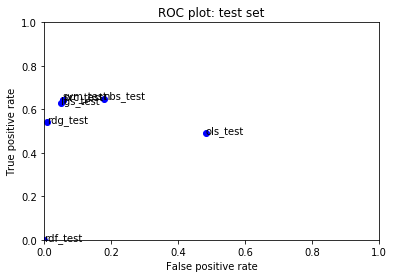

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4837102713431355


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation